title: AML Payouts France    
author: Jesse Scherwitz  
date: 2021-01-05  
region: EU  
link: https://docs.google.com/presentation/d/15M-XFYH8zEA_2La3CnuNAu4gWXsKJo4ylTiBwULovis/edit?usp=sharing   
tags: aml, payout, evaluee, france, account closure  
summary: We identified insufficient data collection to answer basic questions about the performance of our AML payout operations. a) We are currently not tracking which customers have provided an external IBAN which would imply a payout obligation on our end - this should be tracked in Backoffice tickets going forward - and b) Payouts (in particular AML) are not reliably linkable to N26 customers with the tools & process in place. For the payouts that can be linked to users (which is around 80%-90% in 2021), we look at overall payouts in the French market related to AML account closures with positive balance which spiked in Sep & Oct 2021 - while payout (EUR) does not spike accordingly. Possibly this mismatch is driven by high volume account closures which have not been paid out. A link to a list of French users including relevant data related to account closure and payout is provided in teh deck to allow checking high-volume customers manually.

In [456]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [457]:
payouts_granular = pd.read_csv("/app/fra/live/payouts_granular.csv")
trackable_payouts = pd.read_csv("/app/fra/live/share_bo_ticket_given.csv")
monthly_amts = pd.read_csv("/app/fra/live/payout_amts_5.csv")

# Happy to provide the underlying queries or csv's upon request.

In [458]:
monthly_amts["month"] = monthly_amts["month"].str[:10]
monthly_amts = monthly_amts.rename(
    columns={
        "natrium_txn_amount": "AML closure to buffer account (EUR)",
        "payout_amt": "payout (EUR)",
    }
)
monthly_amts["payout_share"] = (
    monthly_amts["payout (EUR)"] / monthly_amts["AML closure to buffer account (EUR)"]
)
monthly_amts["customers_paid_out_share"] = (
    monthly_amts["cnt_payouts"] / monthly_amts["cnt_aml_closures"]
)

trackable_payouts["month"] = trackable_payouts["month"].str[:10]
trackable_payouts = trackable_payouts.rename(
    columns={"share_bo_ticket_given": "share payout linkable to N26 user"}
)

In [459]:
trackable_payouts.month = pd.to_datetime(trackable_payouts.month, format="%Y-%m-%d")

### 1. AML payouts, globally.

####  (involving business_reason = 'CpD_AML')

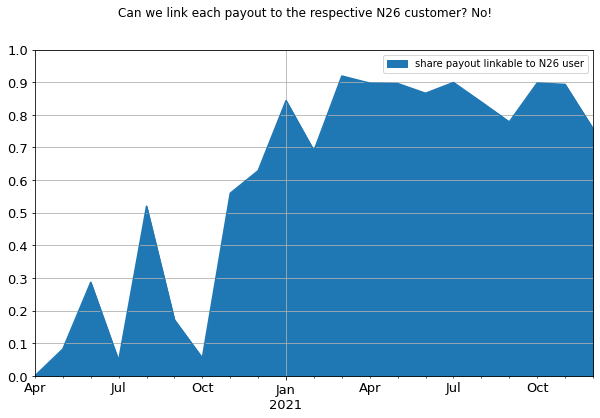

In [460]:
fig, ax = plt.subplots()
ticks = np.arange(0, 1.1, 0.1)

ax.set_yticks(ticks)

trackable_payouts.plot.area(
    x="month", xlabel="", ylim=(0, 1), figsize=(10, 6), ax=ax, fontsize=13, grid=True
)
plt.suptitle("Can we link each payout to the respective N26 customer? No!")
plt.show()

#### Around 10-20% of AML payouts (approved evaluees) are not linkable to the respective N26 customer because no BO-Ticket name was specified by the specialist creating the evaluee!

This means that we currently cannot
- provide reliable data on a "per-case level" and, in particular,
- know which payouts that should have been performed* have NOT been performed

by looking at the data in the DWH only.


### Suggestions:
- create new MANDATORY field "BO-Ticket name" OR "N26 user_id (of customer)" for evaluees [requires changes to EINSTEIN tool]
- temporary solution: tell specialists that they have to enter a BO-Ticket name!





*We're only able to (and then have to) payout if we have an External IBAN provided by the customer! How to measure this reliably?


### 2. We're only able to (and then have to) payout if we have an External IBAN provided by the customer! How to measure this reliably?

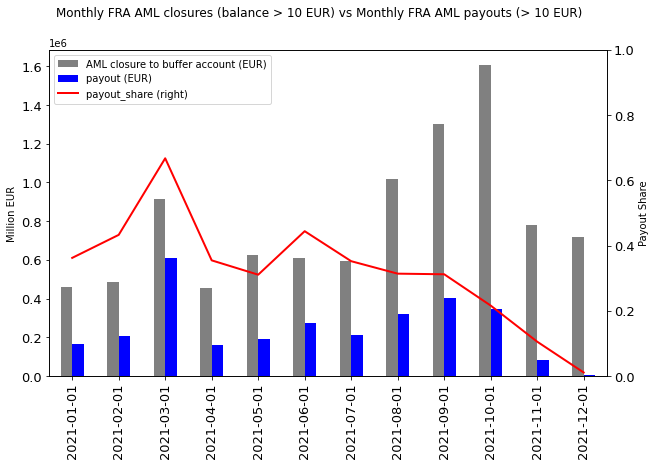

In [461]:
ax = monthly_amts.plot(
    x="month",
    y=["AML closure to buffer account (EUR)", "payout (EUR)"],
    kind="bar",
    color=["grey", "b"],
    xlabel="",
    figsize=(10, 6),
    rot=90,
    fontsize=13,
)
ax2 = monthly_amts.plot(
    x="month",
    y="payout_share",
    c="red",
    secondary_y=True,
    figsize=(10, 6),
    xlabel="",
    rot=90,
    ax=ax,
    fontsize=13,
    linewidth=2,
)

ax.set_ylabel("Million EUR")
ax2.set_ylabel("Payout Share")
ax2.set_ylim([0, 1])

plt.suptitle(
    "Monthly FRA AML closures (balance > 10 EUR) vs Monthly FRA AML payouts (> 10 EUR)"
)

plt.show()

#### We can see that we paid out only ~30% of the (large EUR amount of) positive balances due to AML closures from August to October 2021.

#### This _could_ point at an issue.

#### But be aware that
- it's not clear if the low payout share is mostly due to customers not providing an IBAN or operational issues on our side.
- there may be an expected lag of several weeks between AML closure and payout

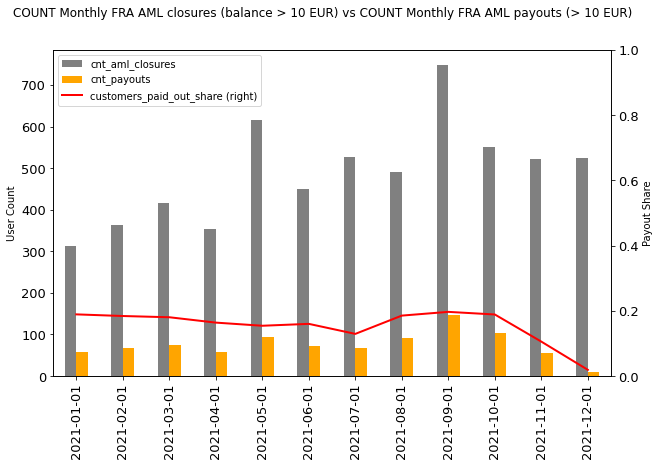

In [462]:
ax = monthly_amts.plot(
    x="month",
    y=["cnt_aml_closures", "cnt_payouts"],
    kind="bar",
    color=["grey", "orange"],
    xlabel="",
    figsize=(10, 6),
    rot=90,
    fontsize=13,
)
ax2 = monthly_amts.plot(
    x="month",
    y="customers_paid_out_share",
    c="red",
    secondary_y=True,
    figsize=(10, 6),
    xlabel="",
    rot=90,
    ax=ax,
    fontsize=13,
    linewidth=2,
)

ax.set_ylabel("User Count")
ax2.set_ylabel("Payout Share")
ax2.set_ylim([0, 1])

plt.suptitle(
    "COUNT Monthly FRA AML closures (balance > 10 EUR) vs COUNT Monthly FRA AML payouts (> 10 EUR)"
)

plt.show()

In [463]:
payouts_granular["closure_month"] = payouts_granular["closure_completed_at"].str[:7]

payouts_granular["closure_month"] = pd.to_datetime(
    payouts_granular.closure_month, format="%Y-%m-%d"
)
payouts_granular = payouts_granular.drop(columns="number_of_payouts")

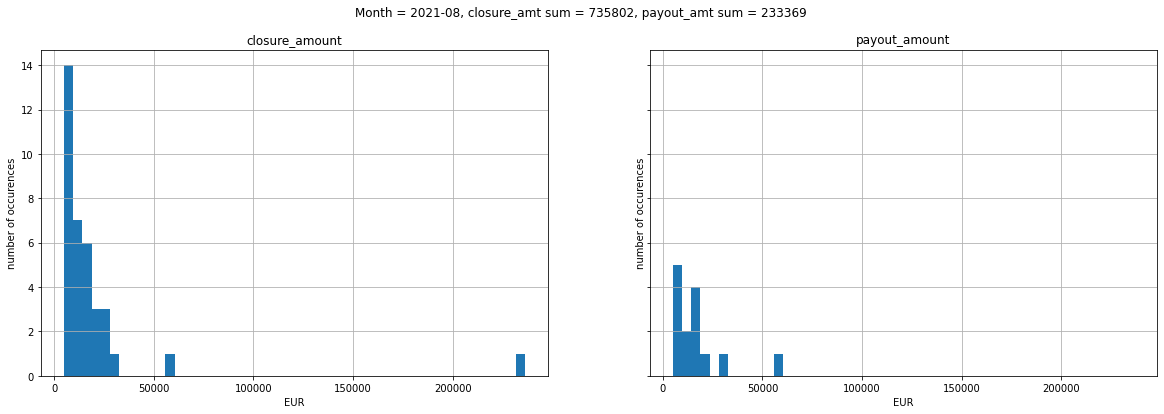

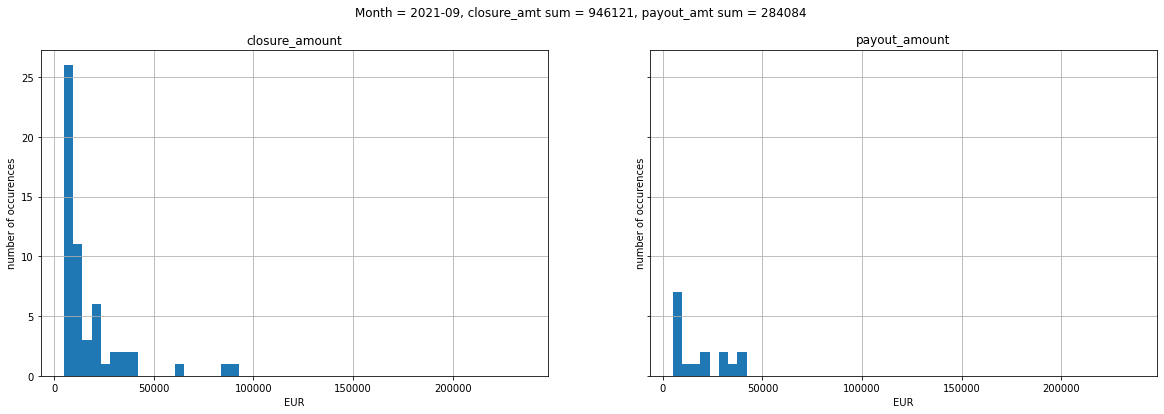

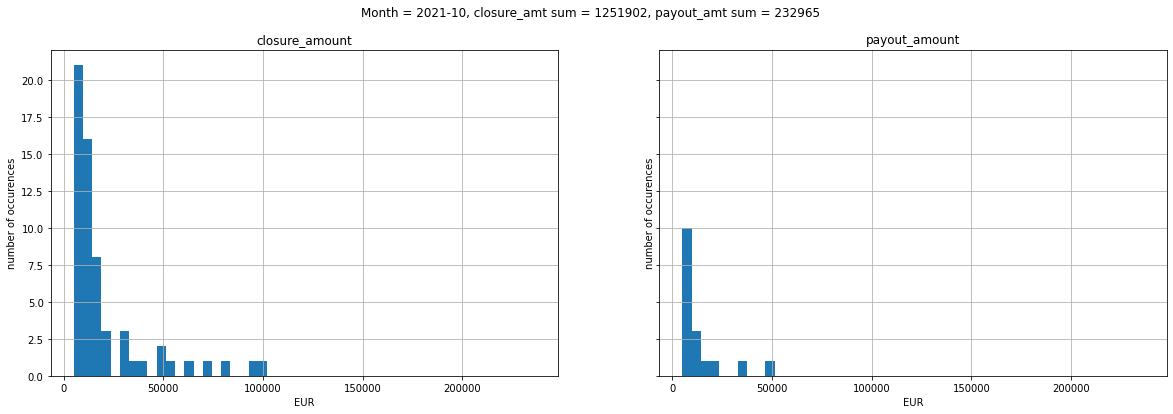

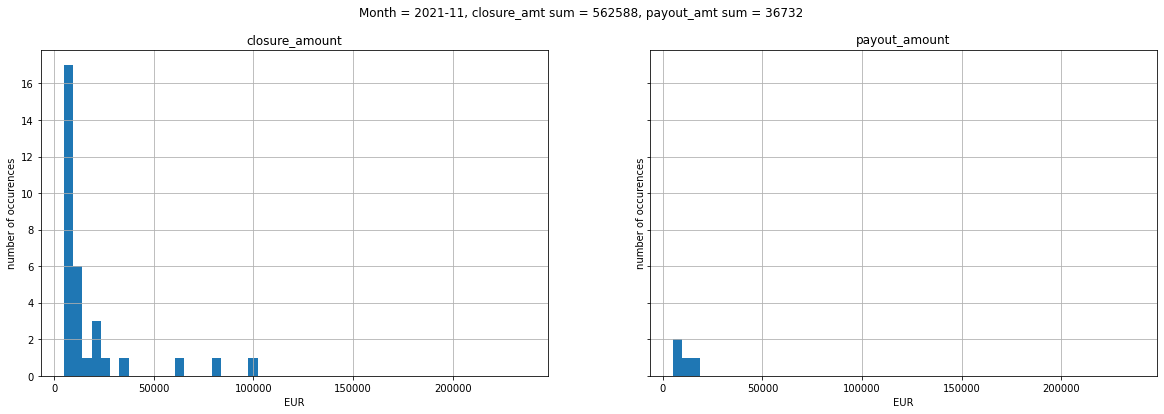

In [467]:
# large txns!

threshold = 5000
payouts_granular_plot = payouts_granular[payouts_granular["closure_amount"] > threshold]

for m in sorted(list(set(payouts_granular_plot.closure_month)))[-5:-1]:
    fig, axes = plt.subplots(
        figsize=(20, 6), sharex=True, sharey=True, ncols=2, nrows=1
    )
    payouts_granular_plot[
        (payouts_granular_plot.closure_month == m)
    ].closure_amount.hist(bins=50, range=(5000, 236381), ax=axes[0])
    payouts_granular_plot[
        (payouts_granular_plot.closure_month == m)
    ].total_payout_amt.hist(bins=50, range=(5000, 236381), ax=axes[1])

    sum_nat = int(
        payouts_granular_plot[
            (payouts_granular_plot.closure_month == m)
        ].closure_amount.sum()
    )
    sum_pay = int(
        payouts_granular_plot[
            (payouts_granular_plot.closure_month == m)
        ].total_payout_amt.sum()
    )
    axes[0].set_title("closure_amount")
    axes[1].set_title("payout_amount")
    axes[0].set_xlabel("EUR")
    axes[1].set_xlabel("EUR")
    axes[0].set_ylabel("number of occurences")
    axes[1].set_ylabel("number of occurences")
    plt.suptitle(
        f"Month = {str(m)[:7]}, closure_amt sum = {sum_nat}, payout_amt sum = {sum_pay}"
    )